<a href="https://colab.research.google.com/github/Txlu-OG/AI-Project/blob/main/AI_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Data Cleaning and Preparation for Stock Market Data

Author: Adedamola Ogundipe

This notebook performs advanced data cleaning, transformation, and preparation on the Daily Historical Stock Prices (1970–2018) dataset.

The main steps are:
- Loads cleaned data from Project 1 (merged_prices_with_sector.csv)
- Performs advanced cleaning (imputation, outliers, error checks)
- Engineers features (returns, rolling stats, ranges)
- Encodes categorical variables (sector)
- Normalizes numeric fields
- Splits into train / validation / test (time-based)
- Generates before/after snapshots and simple visualizations
- Saves cleaned dataset and splits for later modeling
"""

In [1]:
# Imports and configuration
import gc
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")

# Config
DATA_PATH = Path("/content/drive/MyDrive/merged_prices_with_sector.csv")  # output from Project 1
OUTPUT_DIR = Path("project2_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

RANDOM_STATE = 42

# limit to top N tickers by number of rows to save memory
# Set TOP_N_TICKERS = None to use all tickers
TOP_N_TICKERS = 100

In [2]:
# Load data from Project 1
print("Loading merged dataset from Project 1...")
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"{DATA_PATH} not found. Make sure you saved merged.to_csv('merged_prices_with_sector.csv') in Project 1."
    )

df = pd.read_csv(DATA_PATH, parse_dates=["date"])
df = df.set_index("date").sort_index()
print("Initial shape:", df.shape)
print(df.head())

# Keep only columns needed for Project 2
keep_cols = [
    "ticker",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "adj_close",
    "adjclose",
    "sector",
    "year",
    "decade",
]
keep_cols = [c for c in keep_cols if c in df.columns]
df = df[keep_cols].copy()
print("\nAfter column filtering:", df.shape)

# Ensure ticker and sector exist
if "ticker" not in df.columns:
    raise ValueError("Expected a 'ticker' column in merged Project 1 data.")
if "sector" not in df.columns:
    df["sector"] = "Unknown"

# Save small "before cleaning" snapshot for the report
df_initial_snapshot = df.sample(min(5, len(df)), random_state=RANDOM_STATE).sort_index()
df_initial_snapshot.to_csv(OUTPUT_DIR / "snapshot_initial_sample.csv")
print("Saved initial snapshot sample to", (OUTPUT_DIR / "snapshot_initial_sample.csv").resolve())

Loading merged dataset from Project 1...
Initial shape: (20851090, 10)
           ticker      open     close  adj_close       low      high   volume  \
date                                                                            
1970-01-02    XOM  1.929688  1.937500   0.025623  1.925781  1.937500  1174400   
1970-01-02     AA  7.140915  7.140915   1.986261  7.140915  7.225020    22500   
1970-01-02     BA  0.925926  0.979424   0.229325  0.925926  0.979424   634400   
1970-01-02    DIS  0.688281  0.683144   0.282199  0.683144  0.689565  1109700   
1970-01-02     PG  1.710938  1.718750   0.020346  1.708984  1.722656   832000   

            year  decade             sector  
date                                         
1970-01-02  1970    1970             ENERGY  
1970-01-02  1970    1970   BASIC INDUSTRIES  
1970-01-02  1970    1970      CAPITAL GOODS  
1970-01-02  1970    1970  CONSUMER SERVICES  
1970-01-02  1970    1970   BASIC INDUSTRIES  

After column filtering: (20851090, 10)

In [3]:
# Basic type cleaning and downcasting (memory efficiency)
print("\nConverting dtypes and downcasting for memory efficiency...")

# Making sure index is datetime
df.index = pd.to_datetime(df.index, errors="coerce")
df = df[df.index.notna()].sort_values(["ticker", df.index.name])

# Numeric columns
num_cols_raw = [c for c in ["open", "high", "low", "close", "volume", "adj_close", "adjclose"] if c in df.columns]

for col in num_cols_raw:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Year / decade (recompute from index)
df["year"] = df.index.year.astype("int16")
df["decade"] = (df["year"] // 10 * 10).astype("int16")

# Downcast numerics to float32
for col in ["open", "high", "low", "close", "adj_close", "adjclose"]:
    if col in df.columns:
        df[col] = df[col].astype("float32")

if "volume" in df.columns:
    df["volume"] = df["volume"].astype("float32")

df["ticker"] = df["ticker"].astype("category")
df["sector"] = df["sector"].fillna("Unknown").astype("category")

print("\nInfo after downcasting:")
df.info(memory_usage="deep")


Converting dtypes and downcasting for memory efficiency...

Info after downcasting:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20851090 entries, 1999-11-18 to 2018-08-24
Data columns (total 10 columns):
 #   Column     Dtype   
---  ------     -----   
 0   ticker     category
 1   open       float32 
 2   high       float32 
 3   low        float32 
 4   close      float32 
 5   volume     float32 
 6   adj_close  float32 
 7   sector     category
 8   year       int16   
 9   decade     int16   
dtypes: category(2), float32(6), int16(2)
memory usage: 775.9 MB


In [4]:
# restrict to top N tickers to save memory
if TOP_N_TICKERS is not None:
    counts = df["ticker"].value_counts()
    top_tickers = counts.head(TOP_N_TICKERS).index
    df = df[df["ticker"].isin(top_tickers)].copy()
    print(f"\nRestricted to top {TOP_N_TICKERS} tickers by row count.")
    print("New shape:", df.shape)


Restricted to top 100 tickers by row count.
New shape: (1119363, 10)


In [5]:
# Advanced data cleaning
# Missing value imputation
# Error checking (ranges, negatives)

# Handle missing numeric values with forward/backward fill per ticker

numeric_cols = [c for c in ["open", "high", "low", "close", "volume", "adj_close", "adjclose"] if c in df.columns]

print("\nMissing numeric values before imputation:")
print(df[numeric_cols].isna().sum())

def impute_numeric_group(g):
    g = g.copy()
    g[numeric_cols] = g[numeric_cols].ffill().bfill()
    return g

df = df.groupby("ticker", group_keys=False).apply(impute_numeric_group)
df = df.dropna(subset=numeric_cols)

print("\nMissing numeric values after imputation:")
print(df[numeric_cols].isna().sum())
print("Shape after numeric imputation:", df.shape)

# Remove or fix impossible values

# Negative or zero volume: treat as missing then impute again
if "volume" in df.columns:
    bad_vol = df["volume"] <= 0
    print("Rows with non-positive volume:", bad_vol.sum())
    if bad_vol.any():
        df.loc[bad_vol, "volume"] = np.nan
        df = df.groupby("ticker", group_keys=False).apply(impute_numeric_group)
        df = df.dropna(subset=["volume"])
        print("After re-imputing volume, shape:", df.shape)

# Ensure low <= high (swap if inverted)
if "low" in df.columns and "high" in df.columns:
    bad_range = df["low"] > df["high"]
    print("Rows with low > high:", bad_range.sum())
    if bad_range.any():
        tmp_low = df.loc[bad_range, "low"].copy()
        df.loc[bad_range, "low"] = df.loc[bad_range, "high"]
        df.loc[bad_range, "high"] = tmp_low
        print("Fixed low/high swaps.")

# Drop duplicates
before_dupes = df.shape[0]
df = df.reset_index().drop_duplicates().set_index("date")
after_dupes = df.shape[0]
print("Removed duplicate rows:", before_dupes - after_dupes)
print("Shape after cleaning:", df.shape)


Missing numeric values before imputation:
open         0
high         0
low          0
close        0
volume       0
adj_close    0
dtype: int64


/tmp/ipython-input-1363833609.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby("ticker", group_keys=False).apply(impute_numeric_group)
/tmp/ipython-input-1363833609.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("ticker", group_keys=False).apply(impute_numeric_group)



Missing numeric values after imputation:
open         0
high         0
low          0
close        0
volume       0
adj_close    0
dtype: int64
Shape after numeric imputation: (1119363, 10)
Rows with non-positive volume: 0
Rows with low > high: 0
Removed duplicate rows: 0
Shape after cleaning: (1119363, 10)


In [6]:
# Outlier treatment via winsorization (close and volume)
# and before/after columns for comparison
def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    lower = s.quantile(lower_q)
    upper = s.quantile(upper_q)
    return s.clip(lower=lower, upper=upper).astype("float32")

# Pick price column: prefer adjusted close if available
price_col = None
for c in ["adj_close", "adjclose", "close"]:
    if c in df.columns:
        price_col = c
        break

if price_col is None:
    raise ValueError("No price column found among ['adj_close', 'adjclose', 'close'].")

print(f"\nUsing '{price_col}' as primary price column.")

# Keep before-winsorization copies for plots/comparisons
df["price_before_wins"] = df[price_col].astype("float32")
if "volume" in df.columns:
    df["volume_before_wins"] = df["volume"].astype("float32")

# Winsorize price and volume
df["price_wins"] = df.groupby("ticker")[price_col].transform(winsorize_series)

if "volume" in df.columns:
    df["volume_wins"] = df.groupby("ticker")["volume"].transform(winsorize_series)

print("Added winsorized columns: price_wins, volume_wins")


Using 'adj_close' as primary price column.


/tmp/ipython-input-1157461707.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["price_wins"] = df.groupby("ticker")[price_col].transform(winsorize_series)
/tmp/ipython-input-1157461707.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["volume_wins"] = df.groupby("ticker")["volume"].transform(winsorize_series)
/tmp/ipython-input-1157461707.py:6: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for obj

Added winsorized columns: price_wins, volume_wins


/tmp/ipython-input-1157461707.py:6: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return s.clip(lower=lower, upper=upper).astype("float32")
/tmp/ipython-input-1157461707.py:6: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return s.clip(lower=lower, upper=upper).astype("float32")
/tmp/ipython-inp

In [7]:
# Feature engineering
# Daily return
# Rolling moving averages and volatility
# Range and range percentage

print("\nStarting feature engineering...")

# Daily return based on winsorized price
df["return"] = (
    df.groupby("ticker")["price_wins"]
    .pct_change()
    .astype("float32")
)

# Rolling moving averages
df["ma_7"] = (
    df.groupby("ticker")["price_wins"]
    .transform(lambda s: s.rolling(window=7, min_periods=1).mean())
    .astype("float32")
)

df["ma_30"] = (
    df.groupby("ticker")["price_wins"]
    .transform(lambda s: s.rolling(window=30, min_periods=1).mean())
    .astype("float32")
)

# Rolling volatility of returns (30 day)
df["vol_30"] = (
    df.groupby("ticker")["return"]
    .transform(lambda s: s.rolling(window=30, min_periods=1).std())
    .astype("float32")
)

# Intraday range
df["range_hl"] = (df["high"] - df["low"]).astype("float32")
df["range_pct"] = (df["range_hl"] / df["price_wins"]).astype("float32")

# Recompute year/decade from index (in case)
df["year"] = df.index.year.astype("int16")
df["decade"] = (df["year"] // 10 * 10).astype("int16")

print("Feature engineering complete. Current columns:")
print(df.columns)

# Save a small "after feature engineering" snapshot for the report
df_after_fe_snapshot = df.sample(min(5, len(df)), random_state=RANDOM_STATE).sort_index()
df_after_fe_snapshot.to_csv(OUTPUT_DIR / "snapshot_after_feature_engineering_sample.csv")
print("Saved after-feature-engineering snapshot to", (OUTPUT_DIR / "snapshot_after_feature_engineering_sample.csv").resolve())



Starting feature engineering...


/tmp/ipython-input-1167542280.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("ticker")["price_wins"]
/tmp/ipython-input-1167542280.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("ticker")["price_wins"]
/tmp/ipython-input-1167542280.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("ticker")["price_wins"]
/tmp/ipython-input-1167542280.py:30: FutureWarning: The default of obs

Feature engineering complete. Current columns:
Index(['ticker', 'open', 'high', 'low', 'close', 'volume', 'adj_close',
       'sector', 'year', 'decade', 'price_before_wins', 'volume_before_wins',
       'price_wins', 'volume_wins', 'return', 'ma_7', 'ma_30', 'vol_30',
       'range_hl', 'range_pct'],
      dtype='object')
Saved after-feature-engineering snapshot to /content/project2_outputs/snapshot_after_feature_engineering_sample.csv



Creating simple visualizations and summary stats for the report...
Saved summary_outlier_effects to /content/project2_outputs/summary_outlier_effects.csv
       price_before_wins    price_wins  volume_before_wins   volume_wins
count       1.119363e+06  1.119363e+06        1.119363e+06  1.119363e+06
mean        2.191654e+01  2.186364e+01        3.347648e+06  3.268149e+06
std         3.824789e+01  3.802116e+01        7.842698e+06  6.884657e+06
min         2.492395e-06  3.435960e-06        1.000000e+02  1.000000e+02
25%         1.516206e+00  1.520523e+00        2.180000e+05  2.185000e+05
50%         9.471078e+00  9.471078e+00        1.129800e+06  1.127500e+06
75%         2.696000e+01  2.695346e+01        3.590050e+06  3.585600e+06
max         5.336996e+02  4.978782e+02        7.529044e+08  1.420537e+08


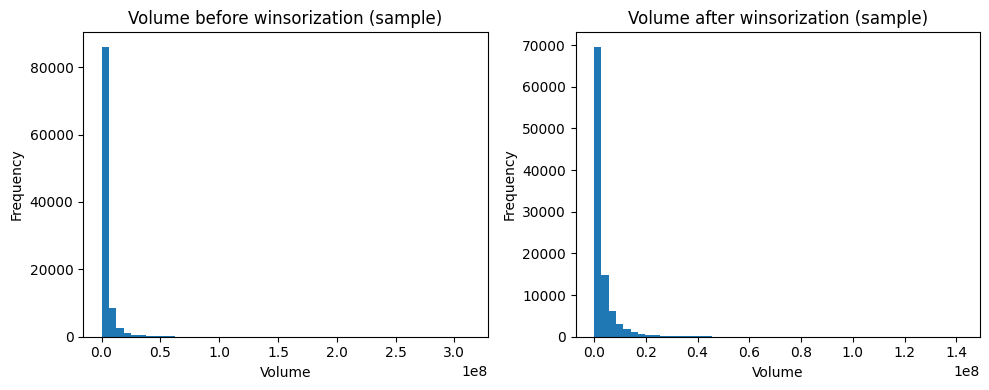

Saved histogram: hist_volume_before_after_winsorization.png


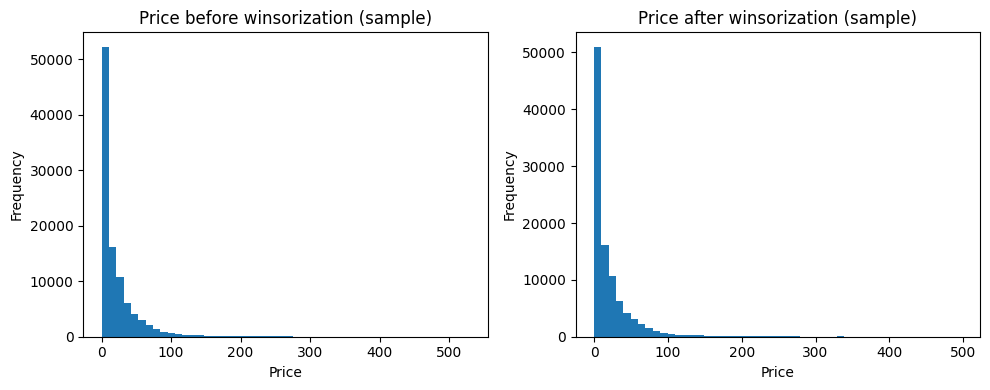

Saved histogram: hist_price_before_after_winsorization.png


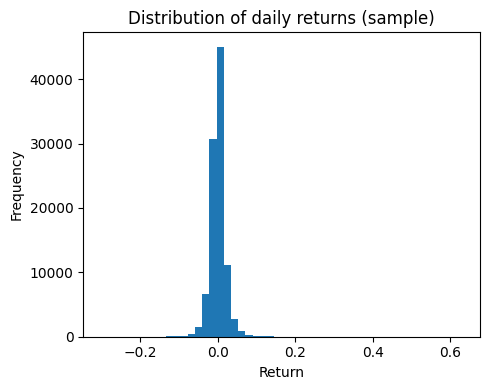

Saved histogram: hist_daily_returns_sample.png


In [8]:
# Visualizations and before/after summaries
# (for reporting: outlier treatment and transformed distributions)

print("\nCreating simple visualizations and summary stats for the report...")

# Summary statistics for price/volume before vs after winsorization
cols_for_summary = ["price_before_wins", "price_wins"]
if "volume_before_wins" in df.columns and "volume_wins" in df.columns:
    cols_for_summary += ["volume_before_wins", "volume_wins"]

summary_outlier_effects = df[cols_for_summary].describe()
summary_outlier_effects.to_csv(OUTPUT_DIR / "summary_outlier_effects.csv")
print("Saved summary_outlier_effects to", (OUTPUT_DIR / "summary_outlier_effects.csv").resolve())
print(summary_outlier_effects)

# Sample subset for histograms to avoid memory issues
plot_sample = df.sample(min(100_000, len(df)), random_state=RANDOM_STATE)

# Volume before vs after winsorization
if "volume_before_wins" in df.columns and "volume_wins" in df.columns:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(plot_sample["volume_before_wins"], bins=50)
    plt.title("Volume before winsorization (sample)")
    plt.xlabel("Volume")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(plot_sample["volume_wins"], bins=50)
    plt.title("Volume after winsorization (sample)")
    plt.xlabel("Volume")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "hist_volume_before_after_winsorization.png", bbox_inches="tight")
    plt.show()
    print("Saved histogram: hist_volume_before_after_winsorization.png")

# Price before vs after winsorization
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(plot_sample["price_before_wins"], bins=50)
plt.title("Price before winsorization (sample)")
plt.xlabel("Price")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(plot_sample["price_wins"], bins=50)
plt.title("Price after winsorization (sample)")
plt.xlabel("Price")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "hist_price_before_after_winsorization.png", bbox_inches="tight")
plt.show()
print("Saved histogram: hist_price_before_after_winsorization.png")

# Return distribution after feature engineering (for report)
plt.figure(figsize=(5, 4))
plt.hist(plot_sample["return"].dropna(), bins=50)
plt.title("Distribution of daily returns (sample)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "hist_daily_returns_sample.png", bbox_inches="tight")
plt.show()
print("Saved histogram: hist_daily_returns_sample.png")

In [9]:
# Encode categorical variables (sector)

print("\nEncoding categorical variables...")

df["sector"] = df["sector"].fillna("Unknown").astype("category")

# One-hot encode sector only (ticker stays as identifier)
df_encoded = pd.get_dummies(df, columns=["sector"], drop_first=True)

print("After sector one-hot encoding:")
df_encoded.info(memory_usage="deep")

# Free the original df to save memory
del df
gc.collect()


Encoding categorical variables...
After sector one-hot encoding:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1119363 entries, 1970-01-02 to 2018-08-24
Data columns (total 31 columns):
 #   Column                        Non-Null Count    Dtype   
---  ------                        --------------    -----   
 0   ticker                        1119363 non-null  category
 1   open                          1119363 non-null  float32 
 2   high                          1119363 non-null  float32 
 3   low                           1119363 non-null  float32 
 4   close                         1119363 non-null  float32 
 5   volume                        1119363 non-null  float32 
 6   adj_close                     1119363 non-null  float32 
 7   year                          1119363 non-null  int16   
 8   decade                        1119363 non-null  int16   
 9   price_before_wins             1119363 non-null  float32 
 10  volume_before_wins            1119363 non-null  float32 


27318

In [10]:
# Define target and drop remaining NaNs
# Target: next-day return

print("\nCreating prediction target (next-day return)...")

df_encoded["target_return_next"] = (
    df_encoded.groupby("ticker")["return"]
    .shift(-1)
    .astype("float32")
)

# Drop rows with missing features or target
df_encoded = df_encoded.dropna(subset=["target_return_next"])

# Also drop any rows with missing key features
feature_candidate_cols = [
    "open", "high", "low", "close", "volume",
    price_col, "price_before_wins", "price_wins",
    "volume_before_wins", "volume_wins",
    "return", "ma_7", "ma_30", "vol_30", "range_hl", "range_pct"
]
feature_candidate_cols = [c for c in feature_candidate_cols if c in df_encoded.columns]

df_encoded = df_encoded.dropna(subset=feature_candidate_cols)
print("Shape after dropping NaNs for target and features:", df_encoded.shape)


Creating prediction target (next-day return)...


/tmp/ipython-input-902901018.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_encoded.groupby("ticker")["return"]


Shape after dropping NaNs for target and features: (1119063, 32)


In [11]:

# Time-based train / validation / test split

print("\nPerforming time-based split into train / validation / test...")

df_encoded = df_encoded.sort_index()

# Define cutoffs
cutoff_train = "2005-12-31"
cutoff_val = "2012-12-31"

train_mask = df_encoded.index <= cutoff_train
val_mask = (df_encoded.index > cutoff_train) & (df_encoded.index <= cutoff_val)
test_mask = df_encoded.index > cutoff_val

train_data = df_encoded.loc[train_mask].copy()
val_data = df_encoded.loc[val_mask].copy()
test_data = df_encoded.loc[test_mask].copy()

print("Train shape:", train_data.shape)
print("Validation shape:", val_data.shape)
print("Test shape:", test_data.shape)

# Features and target
target_col = "target_return_next"

# All sector dummy columns
sector_dummy_cols = [c for c in df_encoded.columns if c.startswith("sector_")]

numeric_features = [
    "open", "high", "low", "close", "volume",
    price_col, "price_wins", "volume_wins",
    "return", "ma_7", "ma_30", "vol_30", "range_hl", "range_pct"
]
numeric_features = [c for c in numeric_features if c in df_encoded.columns]

feature_cols = numeric_features + sector_dummy_cols

print("\nNumber of numeric features:", len(numeric_features))
print("Number of sector dummy features:", len(sector_dummy_cols))
print("Total feature count:", len(feature_cols))


Performing time-based split into train / validation / test...
Train shape: (800994, 32)
Validation shape: (175993, 32)
Test shape: (142076, 32)

Number of numeric features: 14
Number of sector dummy features: 12
Total feature count: 26


In [12]:

# Standardize numeric features (train stats only)
# Memory-friendly: scale in place using train means/stds

print("\nStandardizing numeric features using train statistics...")

# Compute means and stds on training set only
train_means = train_data[numeric_features].mean()
train_stds = train_data[numeric_features].std().replace(0, 1.0)  # avoid divide by zero

# Scale in place on full dataset (still using train stats)
for col in numeric_features:
    df_encoded[col] = (df_encoded[col] - train_means[col]) / train_stds[col]

# Rebuild train/val/test after scaling
train_data = df_encoded.loc[train_mask].copy()
val_data = df_encoded.loc[val_mask].copy()
test_data = df_encoded.loc[test_mask].copy()

print("Standardization complete.")
print("Train numeric feature summary (should be ~0 mean, ~1 std):")
print(train_data[numeric_features].describe().loc[["mean", "std"]])


Standardizing numeric features using train statistics...
Standardization complete.
Train numeric feature summary (should be ~0 mean, ~1 std):
              open          high           low         close        volume  \
mean  9.587977e-08 -6.058500e-09  6.721774e-08  1.205424e-07  8.756797e-08   
std   1.000361e+00  1.000310e+00  1.000363e+00  1.000367e+00  1.000073e+00   

         adj_close    price_wins   volume_wins        return          ma_7  \
mean  6.330265e-08  3.504150e-08 -2.152900e-08  2.986592e-09  8.631311e-08   
std   1.000101e+00  1.000093e+00  9.999639e-01  1.000268e+00  1.000086e+00   

             ma_30        vol_30      range_hl     range_pct  
mean  2.612812e-08  3.752781e-07  3.931956e-08  5.180242e-09  
std   1.000069e+00  1.000236e+00  1.000442e+00  1.000834e+00  


In [13]:
# Final feature matrices and targets

X_train = train_data[feature_cols]
y_train = train_data[target_col]

X_val = val_data[feature_cols]
y_val = val_data[target_col]

X_test = test_data[feature_cols]
y_test = test_data[target_col]

print("\nFinal shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape, "y_val  :", y_val.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)


Final shapes:
X_train: (800994, 26) y_train: (800994,)
X_val  : (175993, 26) y_val  : (175993,)
X_test : (142076, 26) y_test : (142076,)


In [14]:
# Save cleaned data and splits

print("\nSaving cleaned dataset and splits to disk...")

# Full cleaned, encoded dataset
df_encoded.to_csv(OUTPUT_DIR / "cleaned_model_ready_dataset.csv")

# Train/val/test with all columns (including ticker and target)
train_data.to_csv(OUTPUT_DIR / "train_data_full.csv")
val_data.to_csv(OUTPUT_DIR / "val_data_full.csv")
test_data.to_csv(OUTPUT_DIR / "test_data_full.csv")

# features-only and targets-only CSVs
X_train.to_csv(OUTPUT_DIR / "X_train.csv")
y_train.to_csv(OUTPUT_DIR / "y_train.csv")
X_val.to_csv(OUTPUT_DIR / "X_val.csv")
y_val.to_csv(OUTPUT_DIR / "y_val.csv")
X_test.to_csv(OUTPUT_DIR / "X_test.csv")
y_test.to_csv(OUTPUT_DIR / "y_test.csv")

print("All Project 2 outputs saved in:", OUTPUT_DIR.resolve())
print("\nProject 2 data cleaning and preparation complete.")



Saving cleaned dataset and splits to disk...
All Project 2 outputs saved in: /content/project2_outputs

Project 2 data cleaning and preparation complete.
